# Lecture 2

## Generating Images with Pre-trained CNNs

In preperation for this lecture we read _'Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps', Simonyan et al. 2013_ (https://arxiv.org/pdf/1312.6034.pdf).  
Here we want to implement their method to generate images that maximise the activation score of certain output units of AlexNet.  
We will use PyTorch, for more information and tutorials on PyTorch checkout:  
http://pytorch.org/docs/  
http://pytorch.org/tutorials/

In [1]:
#lazy-import all the numpy and matplotlib stuff you need
%pylab inline

#some more imports
import os
cwd = os.getcwd()
from os.path import join as pj
from PIL import Image

#torch imports
import torch
from torch import optim
from torch.autograd import Variable
# import torch.nn.functional as F

#torchvision imports
import torchvision.models as models
from torchvision import transforms

#IPython imports
from IPython import display


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Populating the interactive namespace from numpy and matplotlib


In [2]:
#download alexnet if you haven't done so already and placed it in the current dirctory
model_file_name = 'alexnet-owt-4df8aa71.pth'
if not os.path.exists(pj(cwd, model_file_name)):
    !wget https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth 

In [3]:
#define alexnet architecture, load the pre-trained weights
alexnet = models.alexnet()
alexnet_weights = torch.load(pj(cwd, model_file_name))
alexnet.load_state_dict(alexnet_weights)

#set to evaluation mode to disable Dropout
alexnet.eval()

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)

In [4]:
# define pre and post processing for images using the torchvision helper functions
img_size = 224
prep = transforms.Compose([
        transforms.Scale((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
postpa = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0],
                             std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                             std=[1,1,1]),
    ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [5]:
#load the list of object labels of the ImageNet Dataset that the network was trained on.
with open(pj(pj(os.path.dirname(cwd), 'Lecture1'), 'synset_words.txt')) as syn:
    class_labels = syn.readlines() 
class_labels = [label.split(' ', 1)[1].split('\n')[0] for label in class_labels]

In [6]:
#define image variable to optimise
opt_img = Variable(1e-3 * torch.zeros(1, 3, img_size, img_size), requires_grad=True)

#set all the optimisation parameters
max_iter = 100 #maximum number of iterations to take
lr = 1e0 #learning rate of the optimisation method
lam = 1e3 #weight on the L2 regularisation of the input image
optimizer = optim.SGD([opt_img], lr=lr)
target_class = 968
print('target class: ' + class_labels[target_class])

target class: cup


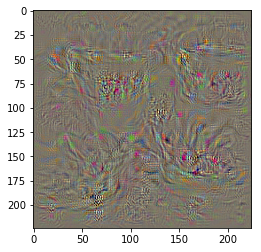

In [7]:
#run the optimisation
n_iter = 0 
while n_iter <= max_iter:
    optimizer.zero_grad()
    output = alexnet(opt_img)
    class_loss = -output[0,target_class]
    l2_loss = lam * (opt_img**2).mean()
    loss = class_loss + l2_loss
    #print loss and show intermediate result image
    print('iter: %d, total loss: %.3f, class loss: %.3f, l2 loss: %.3f'%(n_iter, loss.data[0], class_loss.data[0], l2_loss.data[0]))
    imshow(postp(opt_img.data.clone().squeeze()))
    display.display(gcf())
    display.clear_output(wait=True)
    loss.backward()
    optimizer.step()
    n_iter +=1

## Assignment for next Week
In general, these images don't look that natural. So let's run a little image generation competition until next week:  
__Please modify the code above to improve the quality of the generated images.__  


### Hints
- Play around with the learning rate and the regularisation parameter, try decreasing the learning rate over time.
- Try other optimisation methods from the torch.optim module.
- Checkout this work: _Understanding Neural Networks Through Deep Visualization, Yosinksi et al. 2015_ (https://arxiv.org/pdf/1506.06579.pdf) and test their ideas to regularise the image generation.
- Come up with your own super cool regularisation method that will revolutionise Image Synthesis with CNNs!

And remember, I will get an ice cream for whoever wins the competition ;-)

## Model solutions

Below I implemented the regularisation methods from [Yosinski et al. 2015](https://arxiv.org/pdf/1506.06579.pdf).  
Namely:
- L2 decay
- Blurring the image
- Clipping pixels with small norm
- Clipping pixels with small contribution  

Additionally I implemented:
- A learning rate decay scheme
- Masking the image during optimisation, eg. to only generate something in the center of the image
- Colour averaging during optimisation to generate greyscale images

### Define regularisation functions

In [8]:
#function to decay the learning rate
def decay_lr(optimizer, factor):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= factor 

#function to decay the learning rate
def l2_decay(img, theta):
    img.data *= (1-theta)

import torch.nn as nn
#network module to blur image with a gaussian kernel
class gauss_blur(nn.Module):
    def __init__(self, sigma):
        super(gauss_blur, self).__init__()
        kernel_size = 11 #hardcode this here
        ks_h = (kernel_size-1)/2 #for convenience
        self.blur_pad = nn.ReplicationPad2d(ks_h)
        self.blur_x = nn.Conv2d(3, 3, kernel_size=(1,kernel_size), groups=3, padding=0, bias=False)
        self.blur_y = nn.Conv2d(3, 3, kernel_size=(kernel_size, 1), groups=3, padding=0, bias=False)
        #initialise weights with gaussian
        gaussian = (1./np.sqrt(2*np.pi*sigma**2) * np.exp(-np.arange(-ks_h, ks_h+1)**2/(2.*sigma**2))).astype(np.float32)
        gaussian = np.tile(gaussian[None,None,None,:],(3,1,1,1))
        gaussian = torch.from_numpy(gaussian)
        list(self.blur_x.parameters())[0].data = gaussian.clone()
        list(self.blur_y.parameters())[0].data = gaussian.transpose(2,3).clone()
        
    def forward(self, x):
        x = self.blur_pad(x)
        x = self.blur_x(x)
        x = self.blur_y(x)
        return x

#function to blur image
def blur_image(img, blur):
    img.data = blur(img).data

#function to clip pixels with small norm
def clip_norm(img, percent):
    all_norms = torch.sqrt((img.data**2).sum(1))
    k = int(percent/100. * all_norms.view(-1).size(0))
    ndx = all_norms.le(torch.kthvalue(all_norms.view(-1), k)[0][0])
    img.data[ndx.expand_as(img.data)] = 0
    
#function to clip pixels with small product of pixels with gradient
def clip_grad(img, percent):
    all_norms = torch.abs(img.data*img.grad.data).sum(1)
    k = int(percent/100. * all_norms.view(-1).size(0))
    ndx = all_norms.le(torch.kthvalue(all_norms.view(-1), k)[0][0])
    img.data[ndx.expand_as(img.data)] = 0

#function to multiply image with mask
def mask_image(img, mask):
    img.data = img.data * mask.data

#function to turn image into greyscale by just averaging over color channels
def avg_color(img):
    img.data = img.data.mean(1).expand_as(img.data)

### Define parameters

In [9]:
#define image variable to optimise
opt_img = Variable(1e-2 * torch.randn(1, 3, img_size, img_size), requires_grad=True)

#basic optimisation parameters
max_iter = 300 #maximum number of iterations to take
lr = 1e2 #starting learning rate of the optimisation method
momentum = 0 #momentum parameter
optimizer = optim.SGD([opt_img], lr=lr, momentum=momentum)
target_class = 130
print('target class: ' + class_labels[target_class])

#learning rate decay parameters
decay_iter = max_iter #number of iterations after which to decay the learning rate
decay_factor = 1e-1 #factor by which to multiply the learning rate

#regularisation parameters, set the iter parameter to 'max_iter' to disable a regularisation
#l2 decay parameters
l2_decay_iter = 1
theta_decay = 1e-2

#gaussian blur parameters
blur_iter = 1 #number of iterations after which to blur image
sigma = 1 #std of gaussian kernel
blur = gauss_blur(sigma) #get blur network

#clipping parameters
clip_norm_iter = 1
percent_norm = 20 #percentile of values to clip
clip_grad_iter = 1
percent_grad = 20

#masking parameters
masking = False #whether to apply masking
if masking:
    #define a mask, here a centered blob
    x = np.linspace(0,np.pi,img_size)
    xx,yy = np.meshgrid(x,x)
    blob = torch.from_numpy(np.tile((np.sin(yy)*np.sin(xx))[None,None,:,:],(1,3,1,1)).astype(np.float32))
    mask = opt_img.clone()
    mask.data = blob

#color parameters
no_color = False #whether to get rid of color

target class: flamingo


### Run optimisation

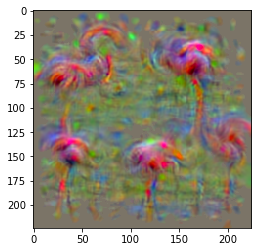

In [10]:
n_iter = 0 
while n_iter < max_iter:
    optimizer.zero_grad()
    output = alexnet(opt_img)
    loss = -output[0,target_class]
    #print loss and show intermediate result image
    print('iter: %d, total loss: %.3f'%(n_iter, loss.data[0]))
    imshow(postp(opt_img.data.clone().squeeze()))
    display.display(gcf())
    display.clear_output(wait=True)
    loss.backward()
    optimizer.step()
    #learning rate decay
    if n_iter%decay_iter == 0:
        decay_lr(optimizer, decay_factor)
    #apply regularisations as needed
    #l2 decay
    if n_iter%l2_decay_iter == 0:
        l2_decay(opt_img, theta_decay)
    #blur image
    if n_iter%blur_iter == 0:
        blur_image(opt_img, blur)
    #clip values with small norm
    if n_iter%clip_norm_iter == 0:
        clip_norm(opt_img, percent_norm)
    #clip values with small contribution
    if n_iter%clip_grad_iter == 0:
        clip_grad(opt_img, percent_grad)
    #multiply mask
    if masking:
        mask_image(opt_img, mask)
    #average over colors
    if no_color:
        avg_color(opt_img)
    n_iter +=1
